In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import pandas as pd
import edward as ed
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import networkx as nx

from edward.models import Normal, Poisson, Bernoulli, InverseGamma
import collections
import pandas as pd
import numpy as np

In [2]:
netw= pd.read_csv('/Users/oliver/Dropbox/EDU/DTU/Blockchain-Transaction-Classification/Data/network_subsample_2.csv', sep=",", header=0)

In [3]:
#Editing data:
netw_uniq = netw[netw['userID_send'] != netw['userID_recv']]                                            #Removing all users who sent to themselves
netw_uniq = netw_uniq.drop_duplicates(subset=['userID_send','userID_recv'], keep='last', inplace=False)  #Removing identical pairs, keeping the last ones

#Finding x% last made links:
netw_uniq=netw_uniq.sort(columns='unixtime', axis=0, ascending=True)
unix = int(np.round(len(netw_uniq)*0.99))
sort = netw_uniq.iloc[unix][1]

#Creating subset:
data = netw_uniq                                                                                         #Creating a subset

#Editing matrix:
#from: https://stackoverflow.com/questions/49095067/how-to-convert-weighted-edge-list-to-adjacency-matrix-in-python
data.drop(['tx_id'], axis=1)                                                                            #Dropping column w. tx_id
cols = ['userID_send','userID_recv','unixtime']                                                          #Rearraning columns
data = data[cols]                                                                                         #Implementing rearranging
data.rename(index=str, columns={"userID_send": "0", "userID_recv": "1", "unixtime": "2"})               #Renaming columns

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,0,1,2
433,11794.0,11711.0,1272243282
970,533.0,11439.0,1273694991
1146,3233.0,12135.0,1276279137
1227,3470.0,533.0,1278767505
1253,38433.0,12135.0,1278922527
1263,44139.0,12135.0,1279006053
1264,12135.0,878798.0,1279011960
1275,878798.0,533.0,1279112968
1313,878798.0,149.0,1279185138
1358,12135.0,165550.0,1279566066


In [4]:
nodes = data.iloc[:, 0].tolist() + data.iloc[:, 1].tolist()

nodes = sorted(list(set(nodes)))

nodes = [(i,nodes[i]) for i in range(len(nodes))]

for i in range(len(nodes)):
    data = data.replace(nodes[i][1], nodes[i][0])

from scipy.sparse import coo_matrix
M = coo_matrix((data.iloc[:,2], (data.iloc[:,0],data.iloc[:,1])), shape=(len(nodes), len(nodes)))
M_zeroing = M.todense()
M_fullData = M.todense()
M_originalZero= M.todense()

#M_zeroing = M                                      #Defining adjecency for zeros
#M_fullData = M                                   #Defining adjecency for non-zeros

#Creating correct indexes in adjecency matrix:
#Original dataset, with all links in adjacency matrix.
M_fullData[M_fullData>0]=1                        #Making all non-zeros into ones
OnesBeforeZeroing=(M_fullData>0).sum()                              #Number of 1'nes before sort= 125944

#Before touching:
(M_fullData>sort).sum()  #=1258
(M_fullData==0).sum()    #=99255017
(M_fullData>0).sum()    #= 125944
#Stats are same afterwards


#Adjecency matrix with only 99% of links:
M_zeroing[M_zeroing>sort]= 0                          #Making all the last 1% into zeros
M_zeroing[M_zeroing>0]=1                              #Making all non-zeros into ones
OnesAfterZeroing=(M_zeroing>0).sum()                              #Number of 1'nes after sort =124686

#Before running 61-63:
(M_zeroing>sort).sum()  #=1258
(M_zeroing==0).sum()    #=99255017
(M_zeroing>0).sum()     #=125944
#After:
(M_zeroing>sort).sum()  #=0
(M_zeroing==0).sum()    #=99256275 (=99255017+1258)
(M_zeroing>0).sum()     #=124686 (125944-1258)


percentage = OnesAfterZeroing/OnesBeforeZeroing                                #Checking the number fits with 1%


#Creating dataset consisting of only ones we have removed:
M_onesRemoved= M_fullData-M_zeroing
(M_onesRemoved>0).sum() #=1258


#Creating a dataset consisting of only the correct zero's - same amount as correct ones (=1258)
(M_originalZero==0).sum()
(M_originalZero==1).sum()
M_originalZero[M_originalZero>0]=1

In [5]:
#Defining variables and model:
x_train= M_zeroing

M_fullDataA= M_fullData
M_onesRemovedA=M_onesRemoved

In [6]:
N = x_train.shape[0]  # number of data points
K = 30  # latent dimensionality

#scale_z = InverseGamma(tf.ones([1,K])*1e-3, tf.ones([1,K])*1e-3)

#scale_b = InverseGamma(1e-3, 1e-3) #Gelman 2006

z2 = Normal(loc = tf.zeros([N, K]), scale = tf.ones([N, K]))

z1 = Normal(loc = tf.zeros([N, K]), scale = tf.ones([N, K]))

b = Normal(loc = tf.zeros(1), scale = tf.ones(1))


# Calculate N x N distance matrix.
# 1. Create a vector, [||z_1||^2, ||z_2||^2, ..., ||z_N||^2], and tile
# it to create N identical rows.
pi1 = tf.tile(tf.reduce_sum(tf.pow(z1, 2), 1, keep_dims=True), [1, N])
pi2 = tf.tile(tf.reduce_sum(tf.pow(z2, 2), 1, keep_dims=True), [1, N])

# 2. Create a N x N matrix where entry (i, j) is ||z_i||^2 + ||z_j||^2
# - 2 z_i^T z_j.
pi = pi1 + tf.transpose(pi2) - 2 * tf.matmul(z1, z2, transpose_b=True)
# 3. minus pairwise distances and make rate along diagonals to
# be close to zero.
pi = -tf.sqrt(pi + tf.diag(tf.zeros(N) + 1e3))

pi = tf.sigmoid(pi + b) #med bias (mange eller få links)

x = Bernoulli(pi)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [7]:
inference = ed.MAP([z1,z2,b], data={x: x_train})

/anaconda/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \
/anaconda/lib/python3.6/site-packages/edward/util/random_variables.py:53: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  not np.issubdtype(value.dtype, np.int) and \


In [8]:
inference.run(n_iter=500)

500/500 [100%] ██████████████████████████████ Elapsed: 6642s | Loss: 72076872.000

In [9]:
#Getting pi for M_onesRemoved:
#type(M_onesRemovedA)
M_onesRemovedtf= tf.convert_to_tensor(M_onesRemovedA, np.float32)
pi_onesRemoved= tf.multiply(M_onesRemovedtf,pi)
pi_onesRemoved_matrix= pi_onesRemoved.eval()
pi_onesRemoved_array=np.asarray(pi_onesRemoved_matrix).reshape(-1)
pi_onesRemoved_array=pi_onesRemoved_array[pi_onesRemoved_array!=0]          #All probabilities for ones_removed
nrOfZeros=len(pi_onesRemoved_array)

#Getting pi for M_fulldata
#type(M_fullDataA)
M_fullDataA= np.asarray(pi_onesRemoved_matrix).reshape(-1)
where_zero=np.where(M_fullDataA==0)[0]
where_zero_index=np.random.choice(where_zero,nrOfZeros)
pi_zeros= pi.eval()
pi_array= np.asarray(pi_zeros).reshape(-1)
pi_originalZeros=pi_array[where_zero_index]                                 #All probabilities for correct zeros

#Creating arrays with zeros and ones:
zeros=np.zeros(nrOfZeros)
ones=np.ones(nrOfZeros)
#Setting together:
y_test= np.concatenate((zeros, ones), axis=0)
p= np.concatenate((pi_originalZeros, pi_onesRemoved_array), axis=0)

In [11]:
#Inserting ROC-method
#Inserting ROC-script (supposed to be imported):
from pylab import *
from scipy.io import loadmat
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
#from toolbox_02450 import rocplot, confmatplot

from sklearn import metrics

def rocplot(p, y):
    
    fpr, tpr, thresholds = metrics.roc_curve(y.ravel(),p.ravel())
    #FPR = fpr
    #TPR = TPR
    #TPR
    AUC = metrics.roc_auc_score(y.ravel(), p.ravel())
    #%%
    plot(fpr, tpr, 'r', [0, 1], [0, 1], 'k')
    grid()
    xlim([-0.01,1.01]); ylim([-0.01,1.01])
    xticks(arange(0,1.1,.1)); yticks(arange(0,1.1,.1))
    xlabel('False positive rate (1-Specificity)')
    ylabel('True positive rate (Sensitivity)')
    title('Receiver operating characteristic (ROC)\n AUC={:.3f}'.format(AUC))


    return AUC, tpr, fpr

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [12]:
rocplot(p, y_test)

(0.9163566212804032,
 array([7.94912560e-04, 1.61367250e-01, 1.61367250e-01, 2.25755167e-01,
        2.25755167e-01, 2.71065183e-01, 2.71065183e-01, 3.10810811e-01,
        3.10810811e-01, 3.26709062e-01, 3.26709062e-01, 3.27503975e-01,
        3.27503975e-01, 3.41812401e-01, 3.41812401e-01, 3.52146264e-01,
        3.52146264e-01, 3.72813990e-01, 3.72813990e-01, 3.82352941e-01,
        3.82352941e-01, 3.98251192e-01, 3.98251192e-01, 4.12559618e-01,
        4.12559618e-01, 4.14149444e-01, 4.14149444e-01, 4.41176471e-01,
        4.41176471e-01, 4.44356121e-01, 4.44356121e-01, 4.57869634e-01,
        4.57869634e-01, 4.65818760e-01, 4.65818760e-01, 4.88076312e-01,
        4.88076312e-01, 4.92050874e-01, 4.92050874e-01, 4.94435612e-01,
        4.94435612e-01, 5.03179650e-01, 5.03179650e-01, 5.07949126e-01,
        5.07949126e-01, 5.15898251e-01, 5.15898251e-01, 5.25437202e-01,
        5.25437202e-01, 5.35771065e-01, 5.35771065e-01, 5.49284579e-01,
        5.49284579e-01, 5.50079491e-01, 5.5

In [20]:
AUC_score = [0.260,0.916,0.387,0.47,0.764,0.612,0.114] 
DIM = [5,30,60,90,120,150,230]

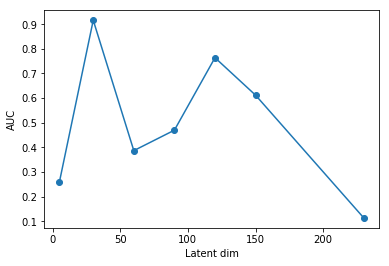

In [29]:
plt.plot(DIM,AUC_score,marker='o')
plt.xlabel("Latent dim")
plt.ylabel("AUC")
plt.savefig('temp.png',dpi = 400)
plt.show()

In [30]:
b.eval()

array([0.25431567], dtype=float32)

In [31]:
z1.eval()

array([[ 1.2376255 , -0.6548865 , -0.16953556, ..., -0.65731674,
         1.0878482 , -1.5149647 ],
       [ 0.2979421 ,  1.6237121 ,  0.936843  , ..., -0.7648687 ,
        -0.44420713,  2.040864  ],
       [-0.1479142 ,  1.5724295 ,  1.709143  , ..., -0.7030897 ,
        -2.3092775 ,  0.94771075],
       ...,
       [ 1.1341289 ,  1.415006  , -0.03549716, ..., -0.47841895,
        -2.4849777 ,  0.7132724 ],
       [-1.3783845 ,  0.2544834 ,  0.02220739, ...,  1.1686165 ,
        -0.6021954 , -0.01564251],
       [-0.1387591 ,  0.7561898 , -0.13361709, ...,  1.541309  ,
        -0.4681174 , -1.5783138 ]], dtype=float32)

In [ ]:
z2.